In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy import stats
from sklearn import model_selection, metrics, linear_model, datasets, feature_selection

import matplotlib.pyplot as plt
%pylab inline


Populating the interactive namespace from numpy and matplotlib


### Import Main Document with Clinical outcomes/characterizations from cbioportal

Data Source: NIH (TCGA) The Cancer Genome Atlas (tcga_brca dataset) and cbioportal for Clinical outcomes

Rationale: RB1 (and its regulators CyclinD-Cdk4/6), TP53, and PI3KC were determined to be drivers of metastasis (details below in case someone is curious)
    - RB1: Involved in Cell cycle regulation (in normal cells, RB1 stops cells from dividing uncontrolably)
    - TP53:DNA damage control (in normal cells this senses DNA damage and activates either repair mecahnisms OR cell death)
    - PI3CK: Cell signalling
    - VEGFC: Angiogenesis (in tumors causes new vasculature to form, to bring more nutrients to the tumor)
    - RRM2: DNA Synthesis
    - COX20: Cell metabolism

Question: Can the mutation status of those genes in the primary tumor predict whether or not there is metastasis (spread of cancer to other tissues potentially disrupting organ function)?

## Steps
1. Download relevant datasets:
    A. Clinical outcomes (met/cancer stage): this comes from cbioportal
    B. Download lists of samples with mutations in TP53, RB1 etc. : this is from NIH-Genomic Database Portal
2. Make sure that both datasets have the same patients
3. Remove unecessary columns and combine mutation and clinical information
4. Change from values to numeric, and get rid of 'Nan' values
5. Build some models.


In [2]:
breast = pd.read_csv('cbioportal_file.csv')#this is the clinical information
breast.head(2) ##way too many uneeded columns

,Study ID,Patient ID,Sample ID,Diagnosis Age,American Joint Committee on Cancer Metastasis Stage Code,Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,American Joint Committee on Cancer Tumor Stage Code,Brachytherapy first reference point administered total dose,...,Staging System.1,Surgery for positive margins,Surgery for positive margins other,Surgical procedure first,Time between clamping and freezing,Time between excision and freezing,Tissue Source Site,Person Neoplasm Status,Vial number,Patient's Vital Status
0,brca_tcga,TCGA-3C-AAAU,TCGA-3C-AAAU-01,55.0,MX,NX,Stage X,6th,TX,NaN,...,NaN,NaN,NaN,Modified Radical Mastectomy,NaN,NaN,3C,WITH TUMOR,A,Alive
1,brca_tcga,TCGA-3C-AALI,TCGA-3C-AALI-01,50.0,M0,N1a,Stage IIB,6th,T2,NaN,...,NaN,NaN,NaN,Lumpectomy,NaN,NaN,3C,TUMOR FREE,A,Alive


In [3]:
#find column names
breast.columns

Index(['Study ID', 'Patient ID', 'Sample ID', 'Diagnosis Age',
       'American Joint Committee on Cancer Metastasis Stage Code',
       'Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code',
       'Neoplasm Disease Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Publication Version Type',
       'American Joint Committee on Cancer Tumor Stage Code',
       'Brachytherapy first reference point administered total dose',
       ...
       'Staging System.1', 'Surgery for positive margins',
       'Surgery for positive margins other', 'Surgical procedure first',
       'Time between clamping and freezing',
       'Time between excision and freezing', 'Tissue Source Site',
       'Person Neoplasm Status', 'Vial number', 'Patient's Vital Status'],
      dtype='object', length=140)

In [4]:
breast.shape
#140 is way too many columns and there will be LOTS OF MISSING DATA

(1108, 140)

### Dont need this many columns, so need to select the ones of interest.


In [5]:
#remove unwanted columns and rename for convenience
df1= breast.iloc[0:][breast.columns[1:5]]
df2=breast.iloc[:][breast.columns[-1::]]
df1['Patient_Alive']= breast.iloc[:][breast.columns[-1::]]
df1['Race']= breast['Race Category']
df1['PR']= breast['PR status by ihc']
df1['ER']= breast['ER Status By IHC']
df1['HER2']= breast['IHC-HER2']
df1['Fraction Genome Altered']= breast['Fraction Genome Altered']
df1.head(2)

,Patient ID,Sample ID,Diagnosis Age,American Joint Committee on Cancer Metastasis Stage Code,Patient_Alive,Race,PR,ER,HER2,Fraction Genome Altered
0,TCGA-3C-AAAU,TCGA-3C-AAAU-01,55.0,MX,Alive,WHITE,Positive,Positive,Negative,0.7787
1,TCGA-3C-AALI,TCGA-3C-AALI-01,50.0,M0,Alive,BLACK OR AFRICAN AMERICAN,Positive,Positive,Positive,0.7164


## Aside: What is ER, PR, HER2?/Why keep them
- Estrogen, Prgesterone and Human Epidermal Growth factor 2, Receptors are overexpressed in certain subtypes of breast cancer, and serve as therapeutic targets. As well as used to categorize Breast Cancer (BC) into subtypes.
- Keeping race because certain BC subtypes are more common in certain races, and its currently not clear why.
- Certain subtypes of BC are also more common in certain age groups as well

image from : http://www.pathophys.org/breast-cancer/


<img src='Capture.png'></img>

In [6]:
df1.shape

(1108, 10)

In [7]:
df1.dtypes

Patient ID                                                   object
Sample ID                                                    object
Diagnosis Age                                               float64
American Joint Committee on Cancer Metastasis Stage Code     object
Patient_Alive                                                object
Race                                                         object
PR                                                           object
ER                                                           object
HER2                                                         object
Fraction Genome Altered                                     float64
dtype: object

#### Because we are going to stich together data from 2 data portals, need to make sure that the same cases are present in both. So need to import GDP dataset now

In [8]:
GDP= pd.read_excel (r'GDPcompile.xlsx', sheet_name='GDPcompile')
GDP.head(2)

,Case ID,Gender
0,TCGA-A2-A0YT,Female
1,TCGA-A8-A08S,Female


In [9]:
GDP.shape

(1098, 2)

In [10]:
GDP['Patient ID']=GDP['Case ID']
GDP.head(2)

,Case ID,Gender,Patient ID
0,TCGA-A2-A0YT,Female,TCGA-A2-A0YT
1,TCGA-A8-A08S,Female,TCGA-A8-A08S


In [11]:
left_joined= pd.merge(GDP, df1, how='right', on='Patient ID')##to get rid of anything not in the GDP database (and therefore doesnt have mutation data)
left_joined.head(2)

,Case ID,Gender,Patient ID,Sample ID,Diagnosis Age,American Joint Committee on Cancer Metastasis Stage Code,Patient_Alive,Race,PR,ER,HER2,Fraction Genome Altered
0,TCGA-A2-A0YT,Female,TCGA-A2-A0YT,TCGA-A2-A0YT-01,56.0,M0,Dead,WHITE,Negative,Positive,NaN,0.5755
1,TCGA-A8-A08S,Female,TCGA-A8-A08S,TCGA-A8-A08S-01,71.0,M0,Alive,NaN,Positive,Positive,Positive,0.4019


In [12]:
left_joined.shape

(1194, 12)

In [13]:
clinical= left_joined.iloc[:][2:]
clinical.head()

,Case ID,Gender,Patient ID,Sample ID,Diagnosis Age,American Joint Committee on Cancer Metastasis Stage Code,Patient_Alive,Race,PR,ER,HER2,Fraction Genome Altered
2,TCGA-A8-A09K,Female,TCGA-A8-A09K,TCGA-A8-A09K-01,68.0,M0,Alive,NaN,Positive,Positive,Negative,0.5029
3,TCGA-A8-A09E,Female,TCGA-A8-A09E,TCGA-A8-A09E-01,73.0,M0,Alive,NaN,Positive,Positive,Positive,0.5448
4,TCGA-A8-A084,Female,TCGA-A8-A084,TCGA-A8-A084-01,81.0,M0,Alive,NaN,Negative,Positive,Negative,0.4237
5,TCGA-A8-A08F,Female,TCGA-A8-A08F,TCGA-A8-A08F-01,59.0,M0,Alive,NaN,Positive,Positive,Negative,0.6614
6,TCGA-GI-A2C8,Female,TCGA-GI-A2C8,TCGA-GI-A2C8-01,63.0,MX,Alive,WHITE,Positive,Positive,Negative,0.5576


In [14]:
clinical.shape

(1192, 12)

In [15]:
cl3=clinical.drop(clinical.columns[[0,1,3,7, 8, 9, 10]],axis=1) ##remove uneeded columns
cl3.head()

,Patient ID,Diagnosis Age,American Joint Committee on Cancer Metastasis Stage Code,Patient_Alive,Fraction Genome Altered
2,TCGA-A8-A09K,68.0,M0,Alive,0.5029
3,TCGA-A8-A09E,73.0,M0,Alive,0.5448
4,TCGA-A8-A084,81.0,M0,Alive,0.4237
5,TCGA-A8-A08F,59.0,M0,Alive,0.6614
6,TCGA-GI-A2C8,63.0,MX,Alive,0.5576


In [16]:
cl3.dropna(axis=0, how='any', inplace= True)##get rid of missing values
cl3.shape

(1165, 5)

In [17]:
clinical.dropna(axis=0, how='any', inplace= True)##get rid of missing values, keeping more columns would mean more missing values
clinical.shape

(816, 12)

In [18]:
clinical.head(2)

,Case ID,Gender,Patient ID,Sample ID,Diagnosis Age,American Joint Committee on Cancer Metastasis Stage Code,Patient_Alive,Race,PR,ER,HER2,Fraction Genome Altered
6,TCGA-GI-A2C8,Female,TCGA-GI-A2C8,TCGA-GI-A2C8-01,63.0,MX,Alive,WHITE,Positive,Positive,Negative,0.5576
8,TCGA-AO-A0J5,Female,TCGA-AO-A0J5,TCGA-AO-A0J5-01,48.0,M1,Dead,WHITE,Negative,Positive,Equivocal,0.1273


In [19]:
clinical.dropna(axis=0, how='any', inplace= True)

In [20]:
clinical.head()

,Case ID,Gender,Patient ID,Sample ID,Diagnosis Age,American Joint Committee on Cancer Metastasis Stage Code,Patient_Alive,Race,PR,ER,HER2,Fraction Genome Altered
6,TCGA-GI-A2C8,Female,TCGA-GI-A2C8,TCGA-GI-A2C8-01,63.0,MX,Alive,WHITE,Positive,Positive,Negative,0.5576
8,TCGA-AO-A0J5,Female,TCGA-AO-A0J5,TCGA-AO-A0J5-01,48.0,M1,Dead,WHITE,Negative,Positive,Equivocal,0.1273
9,TCGA-LL-A6FP,Female,TCGA-LL-A6FP,TCGA-LL-A6FP-01,90.0,MX,Alive,WHITE,Positive,Positive,Equivocal,0.4119
11,TCGA-AR-A2LL,Female,TCGA-AR-A2LL,TCGA-AR-A2LL-01,70.0,M0,Alive,WHITE,Positive,Positive,Equivocal,0.3178
13,TCGA-A7-A0DC,Female,TCGA-A7-A0DC,TCGA-A7-A0DC-01,63.0,M0,Alive,WHITE,Negative,Positive,Negative,0.3192


## Just wanted to show that Males can also get Breast Cancer (although rare) it is still represented in this dataset

In [21]:
QR= clinical['Gender']
print (QR.unique())

['Female' 'Male']


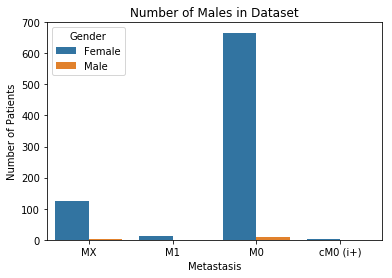

In [23]:
fig1= sns.countplot(x='American Joint Committee on Cancer Metastasis Stage Code', hue='Gender', data=clinical)
plt.xlabel("Metastasis")
plt.ylabel("Number of Patients")
plt.title("Number of Males in Dataset")
plt.show(fig1)

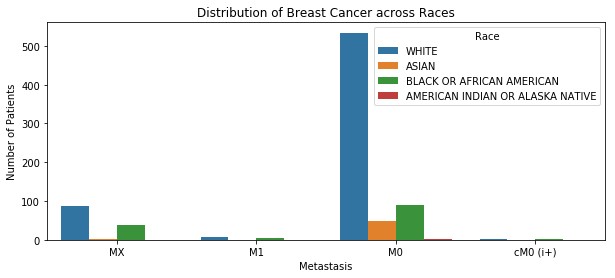

In [24]:
plt.figure(figsize=(10,4))
fig2= sns.countplot(x='American Joint Committee on Cancer Metastasis Stage Code', hue='Race', data=clinical)
plt.xlabel("Metastasis")
plt.ylabel("Number of Patients")
plt.title("Distribution of Breast Cancer across Races")
plt.show(fig2)

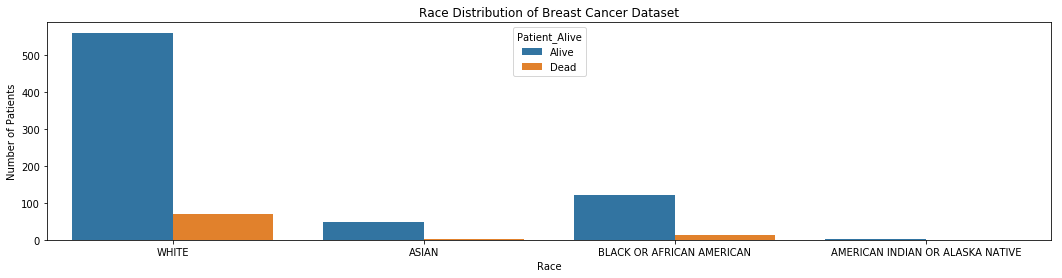

In [26]:
plt.figure(figsize=(18,4))
sns.countplot(x='Race', hue='Patient_Alive', orient="h", data=clinical )
plt.xlabel("Race")
plt.ylabel("Number of Patients")
plt.title("Race Distribution of Breast Cancer Dataset")
plt.show(fig1)
## Conclusions from these graph= There are more white patients, and also not very many metastasic data sets.



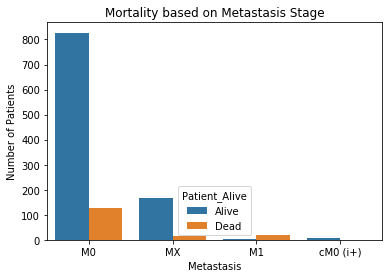

In [28]:
fig3=sns.countplot(x='American Joint Committee on Cancer Metastasis Stage Code', hue='Patient_Alive', data=cl3)
plt.xlabel("Metastasis")
plt.ylabel("Number of Patients")
plt.title("Mortality based on Metastasis Stage")
plt.show(fig3)
##This is refelctive of what is known in clinic...most mortality from Breast Cancer is caused by the metastasis, if BC is caught in its primary stage before it has spread, the prognosis is much better.
## Therefore although the small number of cases makes this graph less convincing, the proportion of Dead to alive is greater in the M1 case.

## Change The Metastasis column
### Distant metastasis (M)
This is our 'y' value

### This is what the code means:

MX: Metastasis cannot be measured. (missing values/unfinished tests, these values will need to be removed)

M0: Cancer has not spread to other parts of the body.

    cM0(i+): Small numbers of cancer cells are found in blood or bone marrow (found only by special tests), or tiny areas of cancer spread (no larger than 0.2 mm) are found in lymph nodes away from the underarm, collarbone, or internal mammary areas.

M1: Cancer has spread to other parts of the body.

In [29]:
#Check for unique values of Metastasis
QC= cl3['American Joint Committee on Cancer Metastasis Stage Code']
print (QC.unique())

['M0' 'MX' 'M1' 'cM0 (i+)']


Need to get rid of MX

In [31]:
cl3= cl3[cl3['American Joint Committee on Cancer Metastasis Stage Code'] != 'MX']##this creates a database without MX
cl3.head()

,Patient ID,Diagnosis Age,American Joint Committee on Cancer Metastasis Stage Code,Patient_Alive,Fraction Genome Altered
2,TCGA-A8-A09K,68.0,M0,Alive,0.5029
3,TCGA-A8-A09E,73.0,M0,Alive,0.5448
4,TCGA-A8-A084,81.0,M0,Alive,0.4237
5,TCGA-A8-A08F,59.0,M0,Alive,0.6614
7,TCGA-A8-A093,61.0,M0,Alive,0.4219


In [32]:
#Check that we really got rid of MX and nan
QD= cl3['American Joint Committee on Cancer Metastasis Stage Code']
print (QD.unique())

['M0' 'M1' 'cM0 (i+)']


In [33]:
#change to numerical values
cl3['metastasis']= cl3['American Joint Committee on Cancer Metastasis Stage Code'].apply(lambda x: 0 if x=='M0' else 1)
cl3['is_alive']=cl3['Patient_Alive'].apply(lambda x: 0 if x== "Dead" else 1)

cl3.head()


,Patient ID,Diagnosis Age,American Joint Committee on Cancer Metastasis Stage Code,Patient_Alive,Fraction Genome Altered,metastasis,is_alive
2,TCGA-A8-A09K,68.0,M0,Alive,0.5029,0,1
3,TCGA-A8-A09E,73.0,M0,Alive,0.5448,0,1
4,TCGA-A8-A084,81.0,M0,Alive,0.4237,0,1
5,TCGA-A8-A08F,59.0,M0,Alive,0.6614,0,1
7,TCGA-A8-A093,61.0,M0,Alive,0.4219,0,1


In [34]:
##Drop unwanted columns
cl2=cl3.drop(cl3.columns[[2,3]],axis=1)
cl2.head()

,Patient ID,Diagnosis Age,Fraction Genome Altered,metastasis,is_alive
2,TCGA-A8-A09K,68.0,0.5029,0,1
3,TCGA-A8-A09E,73.0,0.5448,0,1
4,TCGA-A8-A084,81.0,0.4237,0,1
5,TCGA-A8-A08F,59.0,0.6614,0,1
7,TCGA-A8-A093,61.0,0.4219,0,1


### now we are ready to add in mutation data

## Mutation Data
This Data needs to be downloaded from NIH-GDC Data Portal

In [35]:
###use this code for all the mutation data
cox20 = pd.read_csv('1COX201.csv')
cox20.head()


,Case ID,Vital Status
0,TCGA-A7-A4SD,Alive
1,TCGA-AR-A1AY,Alive
2,TCGA-B6-A0I2,Alive
3,TCGA-E2-A1L7,Alive
4,TCGA-A8-A08B,Alive


In [36]:
s=cl2['Patient ID']
t= cox20['Case ID']
cl2 ['cox20'] = np.where(s.isin(t),1, 0)  ##Whenever the Patient ID matches with the Case ID it means that it has that mutation
cl2.head()

,Patient ID,Diagnosis Age,Fraction Genome Altered,metastasis,is_alive,cox20
2,TCGA-A8-A09K,68.0,0.5029,0,1,0
3,TCGA-A8-A09E,73.0,0.5448,0,1,0
4,TCGA-A8-A084,81.0,0.4237,0,1,0
5,TCGA-A8-A08F,59.0,0.6614,0,1,0
7,TCGA-A8-A093,61.0,0.4219,0,1,0


In [37]:
RB1 = pd.read_csv('1RB1.csv')
RB1.head()
s=cl2['Patient ID']
t= RB1['Case ID']
cl2 ['RB1'] = np.where(s.isin(t),1, 0)
cl2.head()

,Patient ID,Diagnosis Age,Fraction Genome Altered,metastasis,is_alive,cox20,RB1
2,TCGA-A8-A09K,68.0,0.5029,0,1,0,0
3,TCGA-A8-A09E,73.0,0.5448,0,1,0,0
4,TCGA-A8-A084,81.0,0.4237,0,1,0,0
5,TCGA-A8-A08F,59.0,0.6614,0,1,0,1
7,TCGA-A8-A093,61.0,0.4219,0,1,0,0


In [38]:
p53 = pd.read_csv('1TP531.csv')
#p53.head()
s=cl2['Patient ID']
t= p53['Case ID']
cl2 ['TP53'] = np.where(s.isin(t),1, 0)

In [39]:
PI3KC = pd.read_csv('1PI3CK1.csv')
#PI3KCA .head()
s=cl2['Patient ID']
t= PI3KC['Case ID']
cl2 ['PI3CK'] = np.where(s.isin(t),1, 0)

In [40]:
RRM2 = pd.read_csv('RRM2.csv')
#PI3KCA .head()
s=cl2['Patient ID']
t= RRM2['Case ID']
cl2 ['RRM2'] = np.where(s.isin(t),1, 0)

In [41]:
cl2.head()

,Patient ID,Diagnosis Age,Fraction Genome Altered,metastasis,is_alive,cox20,RB1,TP53,PI3CK,RRM2
2,TCGA-A8-A09K,68.0,0.5029,0,1,0,0,0,0,0
3,TCGA-A8-A09E,73.0,0.5448,0,1,0,0,0,0,0
4,TCGA-A8-A084,81.0,0.4237,0,1,0,0,0,0,0
5,TCGA-A8-A08F,59.0,0.6614,0,1,0,1,0,0,0
7,TCGA-A8-A093,61.0,0.4219,0,1,0,0,0,1,0


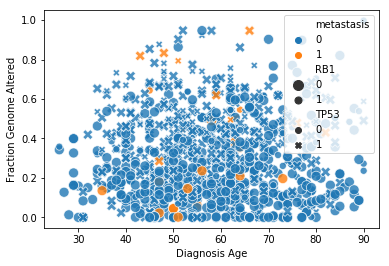

In [79]:
#make some graphs to look at relationship with mutations, and Fraction of genome altered and metastasis. 

sns.scatterplot(data=cl2, x='Diagnosis Age', y='Fraction Genome Altered', hue='metastasis', size = 'RB1', style = 'TP53',
               sizes = (50, 100), alpha=0.8)

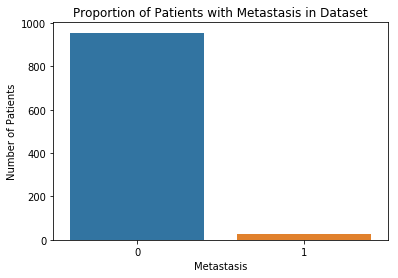

In [42]:
counts= cl3.groupby('Patient ID')['metastasis'].agg(len)

sns.barplot(y=counts, x= counts.index, order=['cox20', 'RB1', 'TP53', 'PI3CK', 'RRM2'])
sns.countplot(x="metastasis", data=cl3)
plt.xlabel("Metastasis")
plt.ylabel("Number of Patients")
plt.title("Proportion of Patients with Metastasis in Dataset")
plt.show(fig1)
##this dataset does not have a lot of people with Metastasis, and its the biggest weakness of the dataset

## Checking to see if the variables are correlated


In [43]:
cl2.corr()

,Diagnosis Age,Fraction Genome Altered,metastasis,is_alive,cox20,RB1,TP53,PI3CK,RRM2
Diagnosis Age,1.000000,0.020016,-0.019518,-0.078569,-0.070152,-0.018250,-0.109993,0.015163,-0.049358
Fraction Genome Altered,0.020016,1.000000,0.052585,-0.060269,0.293959,0.251499,0.358917,0.026586,0.300719
metastasis,-0.019518,0.052585,1.000000,-0.231540,0.004721,0.016240,0.003390,0.004398,-0.023404
is_alive,-0.078569,-0.060269,-0.231540,1.000000,-0.009819,-0.007010,-0.047326,0.026874,-0.059028
cox20,-0.070152,0.293959,0.004721,-0.009819,1.000000,0.141503,0.172852,0.039292,0.229368
RB1,-0.018250,0.251499,0.016240,-0.007010,0.141503,1.000000,0.142229,0.017368,0.140223
TP53,-0.109993,0.358917,0.003390,-0.047326,0.172852,0.142229,1.000000,0.111146,0.228984
PI3CK,0.015163,0.026586,0.004398,0.026874,0.039292,0.017368,0.111146,1.000000,0.078928
RRM2,-0.049358,0.300719,-0.023404,-0.059028,0.229368,0.140223,0.228984,0.078928,1.000000


### There do not seem to be any strong correlations between metastasis and my chosen variables, with the greatest relation being with the "Fraction Genome Altered", which makes sense, because increased genomic instability leads to more mutations that can lead to more aggressive tumors.

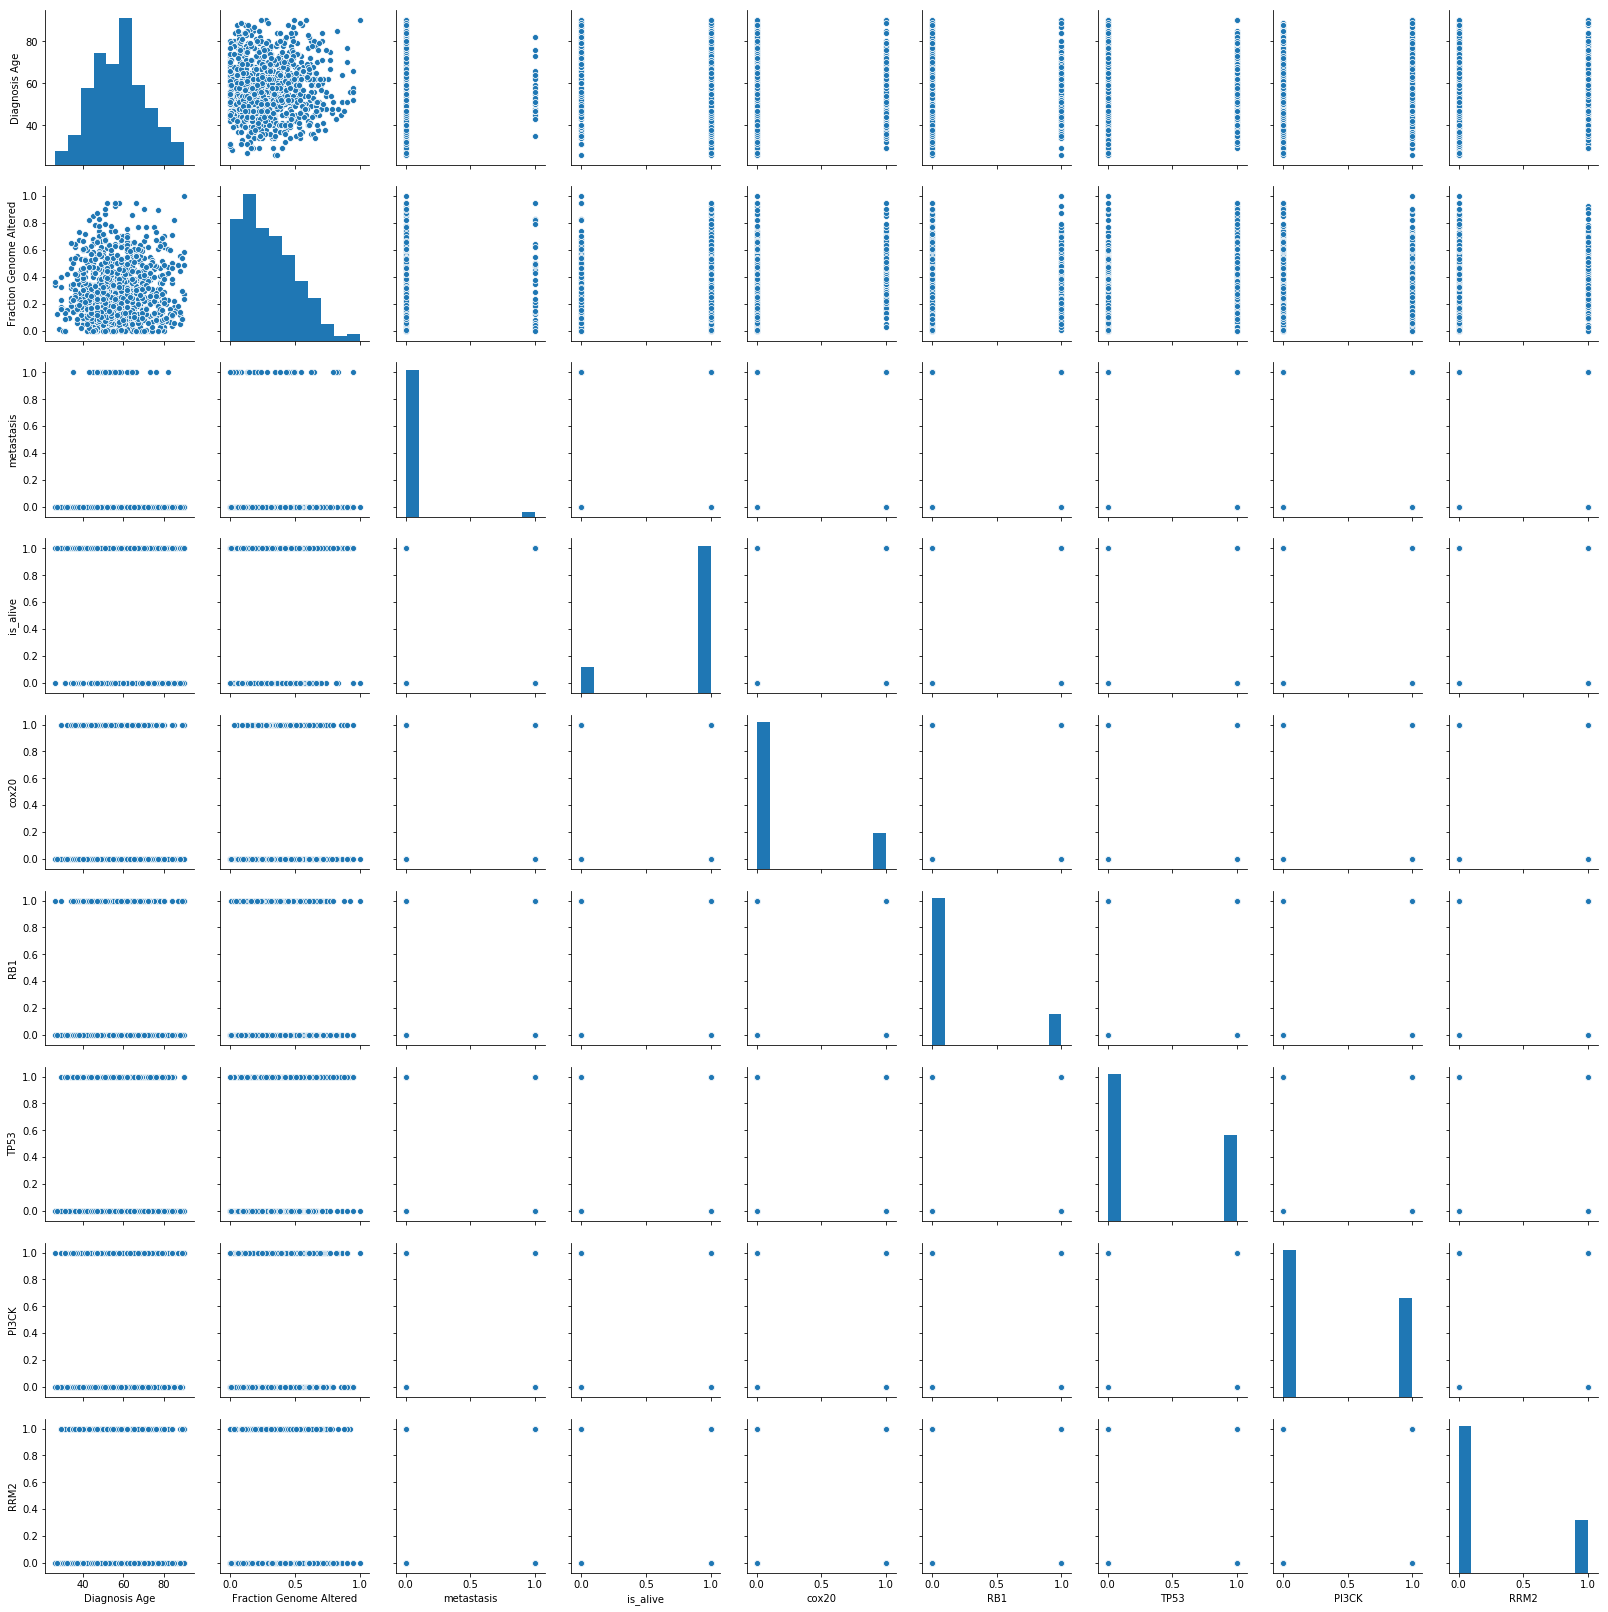

In [48]:
sns.pairplot(cl2)# difficult to detect trends within this dataset

In [49]:
cl2.columns

Index(['Patient ID', 'Diagnosis Age', 'Fraction Genome Altered', 'metastasis',
       'is_alive', 'cox20', 'RB1', 'TP53', 'PI3CK', 'RRM2'],
      dtype='object')

## Although dataset is not ideal (limitations discussed at the end of notebook), I decided to move forward in making models with the cleaned dataset

## Lets make some models

Try out logistic regression model.

In [50]:
include_col= ['Diagnosis Age', 
              'Fraction Genome Altered', 
              'is_alive', 
              'cox20', 
              'RB1', 
              'TP53', 
              'PI3CK', 
              'PI3CK', 
              'RRM2']


In [51]:
X= cl2[include_col]
y= cl2['metastasis']==1

In [52]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)
metmodel = linear_model.LogisticRegression()
metmodel.fit(X_train, y_train)


C:\Users\Ioulia Vorobieva\Anaconda35\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [53]:
metmodel.score(X_test,y_test)  ## 96.6% is not bad

0.9662162162162162

In [54]:
pd.DataFrame(list(zip(include_col, np.transpose(metmodel.coef_)))).sort_values(by=1)

,0,1
2,is_alive,[-2.089594409828099]
4,RB1,[-0.2962786885139811]
3,cox20,[-0.12289689840064788]
6,PI3CK,[-0.059482614439390014]
7,PI3CK,[-0.059482614439390014]
8,RRM2,[-0.046095905768478745]
0,Diagnosis Age,[-0.0225428628515738]
5,TP53,[0.1740865141924353]
1,Fraction Genome Altered,[0.5686261828918426]


### Next I wanted to check how good the fit actually was using the logistic regression model
#### The R-squared value is 0, which means there is no correlation. I think this is because the Number of Metastasis positive patients were too low in this dataset. It may also be that the particular mutations I selected are not good predictors of metastasis, and others could be explored

In [56]:
import statsmodels.formula.api as smf  # import the formula tools
cl2_reg = smf.ols("metastasis ~ RB1 + TP53 + cox20 + PI3CK", data=cl2).fit()  # this is a shortcut to the above
cl2_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             metastasis   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.07003
Date:                Sun, 16 Jun 2019   Prob (F-statistic):              0.991
Time:                        23:32:17   Log-Likelihood:                 352.59
No. Observations:                 984   AIC:                            -695.2
Df Residuals:                     979   BIC:                            -670.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0275      0.008      3.315      0.001       0.011       0.044
RB1            0.0071      0.015      0.486      0.627      -0.022       0.036
TP53           0.0001      0.012      0.009      0.993      -0.022       0.023
cox20          0.0010      0.014      0.070      0.945      -0.026       0.028
PI3CK          0.0014      0.011      0.124      0.901      -0.020       0.023
==============================================================================
Omnibus:                     1066.643   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39423.534
Skew:                           5.562   Prob(JB):                         0.00
Kurtosis:                      31.945   Cond. No.                         3.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
metmodel.predict_proba(X_test)##probability that its correct

array([[0.97901993, 0.02098007],
       [0.98412463, 0.01587537],
       [0.99050954, 0.00949046],
       [0.88732397, 0.11267603],
       [0.99017307, 0.00982693],
       [0.88636499, 0.11363501],
       [0.99375337, 0.00624663],
       [0.98094062, 0.01905938],
       [0.98603681, 0.01396319],
       [0.98909514, 0.01090486],
       [0.98394991, 0.01605009],
       [0.98513456, 0.01486544],
       [0.98681443, 0.01318557],
       [0.98519615, 0.01480385],
       [0.82148342, 0.17851658],
       [0.98425515, 0.01574485],
       [0.88001821, 0.11998179],
       [0.98703424, 0.01296576],
       [0.98344074, 0.01655926],
       [0.97934386, 0.02065614],
       [0.90192554, 0.09807446],
       [0.97821836, 0.02178164],
       [0.98360779, 0.01639221],
       [0.98887002, 0.01112998],
       [0.92847187, 0.07152813],
       [0.9932878 , 0.0067122 ],
       [0.98160615, 0.01839385],
       [0.84675554, 0.15324446],
       [0.97864221, 0.02135779],
       [0.96597998, 0.03402002],
       [0.

# Try out Guassian Model and Bernoulli 
## I wanted to see which model of probability would work best with this dataset.

In [58]:
from sklearn.feature_extraction import text  # some text processing tools
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB

In [59]:
##
X = cl2[include_col] ##making this the feature data set
y = cl2['metastasis']==1 ##this is our 'y'or what we're trying to predict

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

GNB_model = GaussianNB()
GNB_model.fit(X_train,y_train)
GNB_model.score(X_test,y_test)

0.9594594594594594

In [60]:
X = cl2[include_col]##making this the feature data set
y = cl2['metastasis']==1 ##this is our 'y'or what we're trying to predict
bt_nb = BernoulliNB()
bt_nb.fit(X_train,y_train)
bt_nb.score(X_test,y_test)

0.9662162162162162

## Both give a good score but Bernoulli NB is a little better

## Now lets try to make a Decision Tree

In [61]:
from sklearn import tree

In [62]:
metmodel_tree= tree.DecisionTreeClassifier(max_depth=6)####max depath to combat overfitting
metmodel_tree.fit(X_train,y_train)
metmodel_tree.score(X_test,y_test)

0.956081081081081

In [63]:
columns= [include_col]
metmodel_tree.feature_importances_

array([0.29504921, 0.55088306, 0.08612006, 0.0665415 , 0.        ,
       0.        , 0.        , 0.        , 0.00140618])

In [64]:
columns= ['Diagnosis Age', 
              'Fraction Genome Altered', 
              'is_alive', 
              'cox20', 
              'RB1', 
              'TP53', 
              'PI3CK', 
              'PI3CK', 
              'RRM2']

data= np.array([[0.29504921, 0.49173506, 0.08612006, 0.0665415 , 0.0, 0.059148  , 0. , 0.0 , 0.00140618]])
pd.DataFrame(data=data, columns=columns )

,Diagnosis Age,Fraction Genome Altered,is_alive,cox20,RB1,TP53,PI3CK,PI3CK,RRM2
0,0.295049,0.491735,0.08612,0.066542,0.0,0.059148,0.0,0.0,0.001406


##  I made an aditional dataset that included Race and receptor expression in the predictions

In [65]:
alt_col= pd.read_pickle('alt_col_cl3.pickle') ##cleaned in separate file
alt_col.head()

,Patient ID,Diagnosis Age,Race,PR,ER,HER2,Fraction Genome Altered,metastasis,is_alive,RB1,TP53,RRM2,PI3CK,Native,Asian,African American,White
8,TCGA-AO-A0J5,48.0,WHITE,1,1,1,0.1273,1,0,0,0,0,1,0,0,0,1
11,TCGA-AR-A2LL,70.0,WHITE,1,1,1,0.3178,0,1,1,0,0,0,0,0,0,1
13,TCGA-A7-A0DC,63.0,WHITE,1,1,1,0.3192,0,1,1,0,1,1,0,0,0,1
14,TCGA-A7-A0DC,63.0,WHITE,1,1,1,0.3192,0,1,1,0,1,1,0,0,0,1
15,TCGA-BH-A1F5,62.0,WHITE,1,1,1,0.1457,0,0,0,0,0,0,0,0,0,1


In [66]:
alt_col.columns

Index(['Patient ID', 'Diagnosis Age', 'Race', 'PR', 'ER', 'HER2',
       'Fraction Genome Altered', 'metastasis', 'is_alive', 'RB1', 'TP53',
       'RRM2', 'PI3CK', 'Native', 'Asian', 'African American', 'White'],
      dtype='object')

In [67]:
alt_col.corr()

,Diagnosis Age,PR,ER,HER2,Fraction Genome Altered,metastasis,is_alive,RB1,TP53,RRM2,PI3CK,Native,Asian,African American,White
Diagnosis Age,1.000000,NaN,NaN,NaN,-0.014908,-0.019924,-0.094913,0.011090,-0.091457,-0.050854,0.059540,-0.006556,-0.072806,-0.061276,0.098339
PR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HER2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fraction Genome Altered,-0.014908,NaN,NaN,NaN,1.000000,0.021196,-0.074884,0.224598,0.402848,0.309044,0.040701,-0.019260,0.032929,0.085465,-0.091359
metastasis,-0.019924,NaN,NaN,NaN,0.021196,1.000000,-0.211571,-0.022882,0.004679,-0.038643,-0.005709,-0.005769,-0.043547,0.139582,-0.090169
is_alive,-0.094913,NaN,NaN,NaN,-0.074884,-0.211571,1.000000,0.041177,-0.039931,-0.059132,0.043788,0.013504,0.053637,-0.008337,-0.027964
RB1,0.011090,NaN,NaN,NaN,0.224598,-0.022882,0.041177,1.000000,0.186276,0.145410,0.043972,-0.016303,0.045704,0.031366,-0.053891
TP53,-0.091457,NaN,NaN,NaN,0.402848,0.004679,-0.039931,0.186276,1.000000,0.222314,0.104603,0.047381,0.120312,0.075743,-0.144192
RRM2,-0.050854,NaN,NaN,NaN,0.309044,-0.038643,-0.059132,0.145410,0.222314,1.000000,0.074641,-0.022665,0.062400,-0.004178,-0.033760


In [68]:
alt_col.dtypes

Patient ID                  object
Diagnosis Age              float64
Race                        object
PR                           int64
ER                           int64
HER2                         int64
Fraction Genome Altered    float64
metastasis                   int64
is_alive                     int64
RB1                          int32
TP53                         int32
RRM2                         int32
PI3CK                        int32
Native                       uint8
Asian                        uint8
African American             uint8
White                        uint8
dtype: object

In [69]:
include_col2= ['Diagnosis Age', 
               'PR', 
               'ER', 
               'HER2',
               'Fraction Genome Altered', 
               'is_alive', 
               'RB1', 
               'TP53',
               'RRM2', 
               'PI3CK', 
               'Native', 
               'Asian', 
               'African American', 
               'White']


In [70]:
X= alt_col[include_col2]
y= alt_col['metastasis']==1
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

In [71]:
metmodel_1tree= tree.DecisionTreeClassifier(max_depth=6)####max depath to combat overfitting
metmodel_1tree.fit(X_train,y_train)
metmodel_1tree.score(X_test,y_test)

0.9732142857142857

In [72]:
metmodel_1tree.feature_importances_

array([0.12072948, 0.        , 0.        , 0.        , 0.55122828,
       0.09571816, 0.        , 0.08016487, 0.05926297, 0.02616806,
       0.        , 0.        , 0.06672819, 0.        ])

In [73]:
columns= ['Diagnosis Age', 
               'PR', 
               'ER', 
               'HER2',
               'Fraction Genome Altered', 
               'is_alive', 
               'RB1', 
               'TP53',
               'RRM2', 
               'PI3CK', 
               'Native', 
               'Asian', 
               'African American', 
               'White']

data= np.array([[0.17999245, 0.0, 0.0, 0.0, 0.63024557, 0.09571816, 0.0, 0.00114757, 0., 0.02616806,0.0 , 0.0, 0.06672819, 0.0 ]])


pd.DataFrame(data=data, columns=columns )

,Diagnosis Age,PR,ER,HER2,Fraction Genome Altered,is_alive,RB1,TP53,RRM2,PI3CK,Native,Asian,African American,White
0,0.179992,0.0,0.0,0.0,0.630246,0.095718,0.0,0.001148,0.0,0.026168,0.0,0.0,0.066728,0.0


# Conclusions/Results
This model shows little correlation between the mutated genes in the primary tumor and whether the patient develops metastasis. ALthough after creating 2 tree models, logistic regression model, and a Bernoulli and Guassian NB model, although the test scores are good, I believe they are over fitted. Fraction of Genome altered and Diagnosis age are the most correlated with metastasis incidence.
## Limitations/Downfalls
    1. Dataset not large enough to make mutation analysis per each subtype of Breast Cancer
    2. Dataset has low number of recorded metastasis
## Things I'd change For Next Time
    1. Combine other datasets together to:
        A. Increase number of patients with metastasis in the dataset.
        B. Increase number of potential metastasis "drivers" to see whether they could serve as a metastatic biomarker. 
        C. Be able to separate the analysis by subtype.


Thank you for a great course, I will definitely continue to experiment with python!
